# STB600 Credit Piece Detection - Workbook

This notebook demonstrates the image processing pipeline for detecting and decoding colored LEGO-like pieces with encoded values.

All core functionality is imported from the `stb600_lib` library.

## 1. Imports & Setup

In [1]:
# Core dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Import from local library
from stb600_lib import (
    # IO
    load_source_cv2,
    # Display
    show_image,
    annotate_part_result,
    draw_labeled_contours_colored,
    draw_horizontal_rois_from_boundaries,
    resize_to_screen,
    make_row,
    make_grid,
    # Color processing
    remove_color_hsv,
    detect_piece_color_and_check_size,
    detect_color_parts,
    # Morphology
    binarize_and_invert,
    apply_morphological_opening,
    apply_morphological_closing,
    # Contours
    find_and_draw_contours_with_area_limits,
    extract_contour_features,
    label_contour_by_extent_and_area,
    crop_and_align_vertical,
    # ROI
    split_fixed_horizontal_rois_and_count,
    # Decoding
    decode_roi_to_number,
    compute_total_value_from_rois,
    # Transforms
    rotate_if_marker_bottom,
    # Pipeline
    process_piece,
)

print("Library loaded successfully!")

Library loaded successfully!


## 2. Configuration

In [2]:
# Path to test image
IMAGE_PATH = "images/blue.png"

# Debug mode - show intermediate results
DEBUG = True

# Processing parameters (defaults work well for most cases)
CONFIG = {
    # Green background removal
    "green_color": "green",
    
    # Main contour detection
    "main_min_area": 10_000,
    "main_max_area": 200_000,
    
    # Color-size thresholds for piece classification
    "small_area_max": 90_000,
    "medium_area_max": 130_000,
    
    # Labeling thresholds for inner parts
    "extent_threshold": 0.5,
    "label_small_area_max": 1000,
    "label_medium_area_max": 2100,
}

## 3. Quick Pipeline (Single Function Call)

Loaded: image


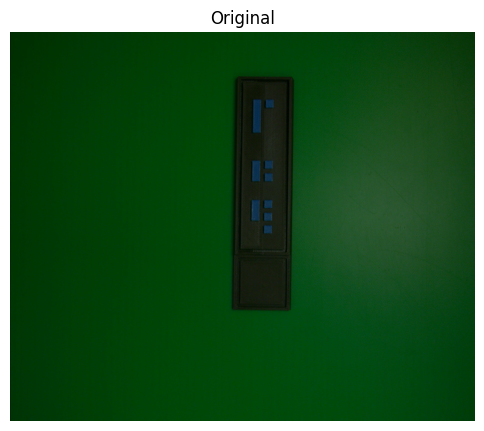

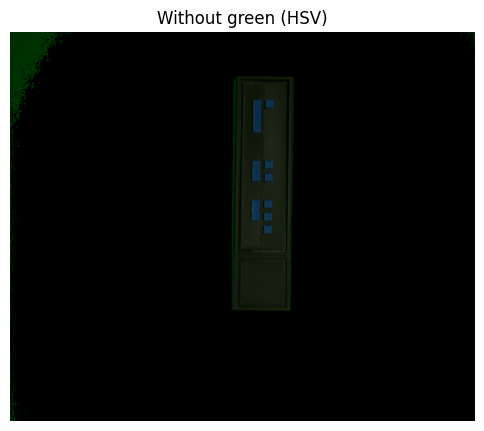

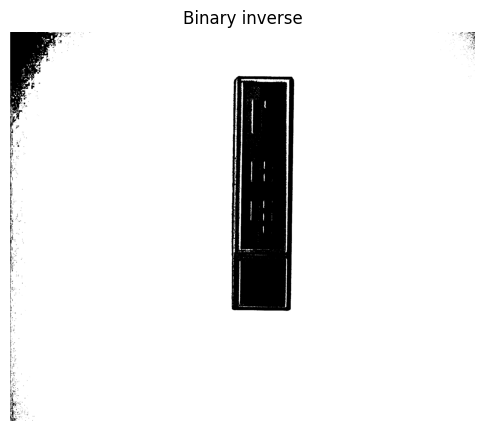

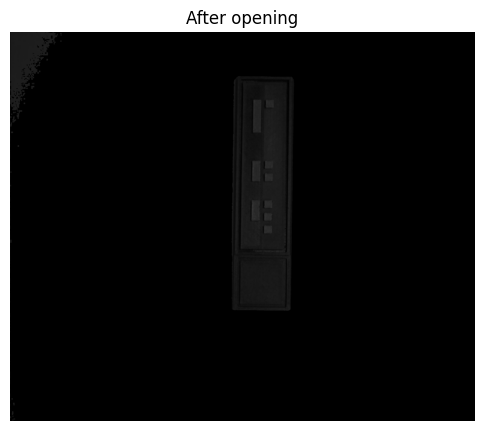

Total contours found: 69
Contours after area filter [10000, 200000]: 1


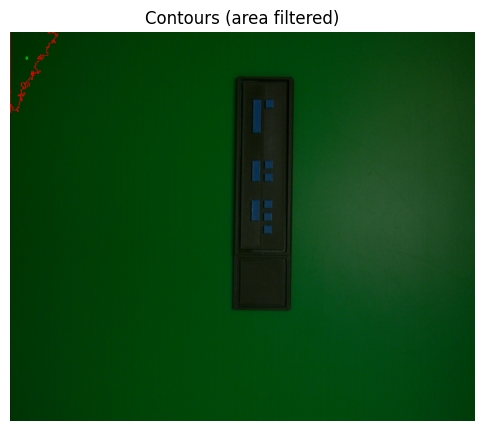

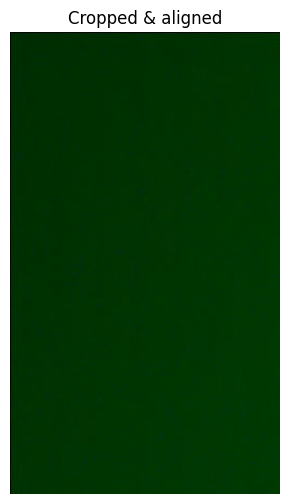

AREA: 54575.5
Piece color: blue, size: SMALL, consistent: False


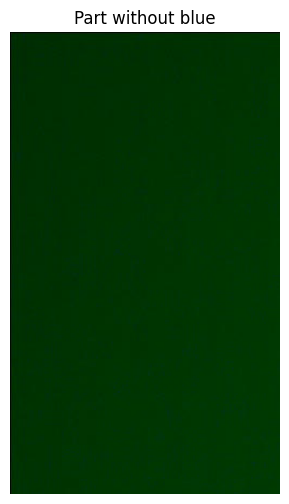

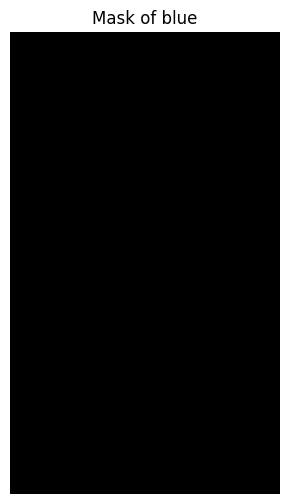

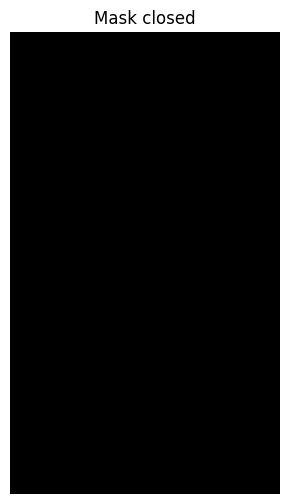

Total contours found: 0
Contours after area filter [100, 200000]: 0


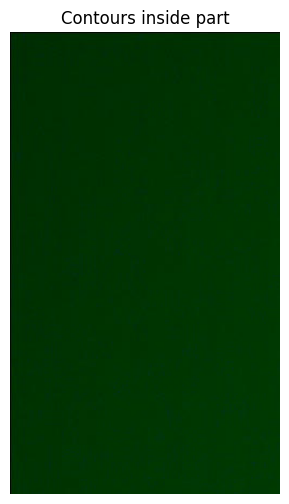

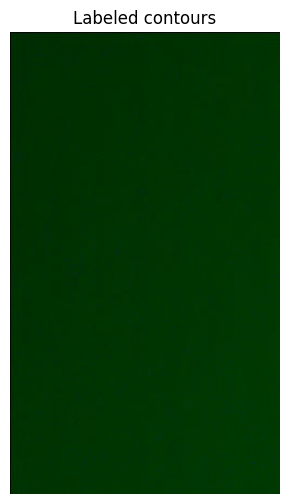

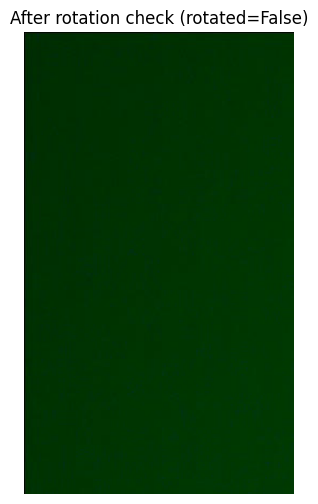

ROI 0 (y: 0-129) -> {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 1 (y: 129-215) -> {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 2 (y: 215-430) -> {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}


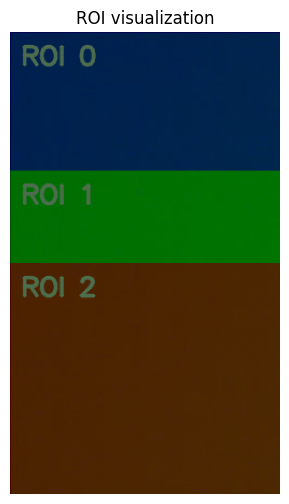

ROI 0 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 1 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 2 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
Total value: None


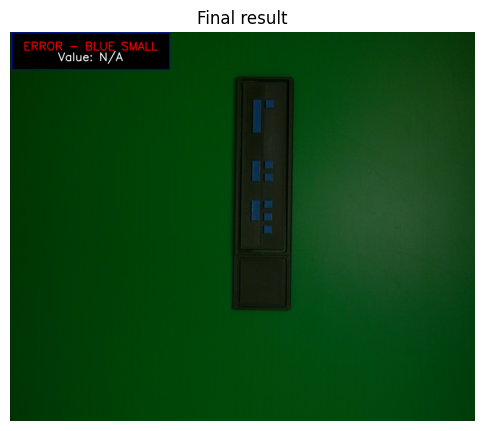


=== RESULTS ===
Piece color: blue
Size label: SMALL
Consistent: False
Total value: None
Decoded digits: [None, None, None]


In [4]:
# Load image
src_type, img = load_source_cv2(IMAGE_PATH)
print(f"Loaded: {src_type}")

# Run complete pipeline
result = process_piece(img, debug=DEBUG, **CONFIG)

# Show results
print(f"\n=== RESULTS ===")
print(f"Piece color: {result.piece_color}")
print(f"Size label: {result.size_label}")
print(f"Consistent: {result.is_consistent}")
print(f"Total value: {result.total_value}")
print(f"Decoded digits: {result.decoded_digits}")

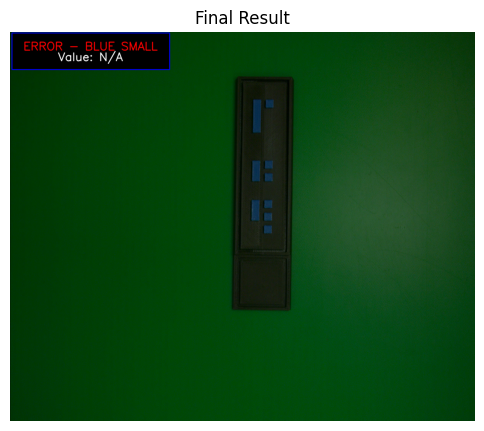

In [5]:
# Display final annotated result
show_image(result.annotated_image, "Final Result")

## 4. Step-by-Step Processing (For Exploration/Debugging)

Use these cells to inspect individual steps of the pipeline.

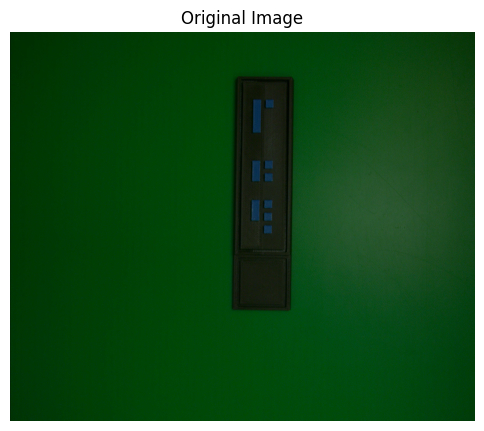

In [6]:
# Step 1: Load image
src_type, img = load_source_cv2(IMAGE_PATH)
show_image(img, "Original Image")

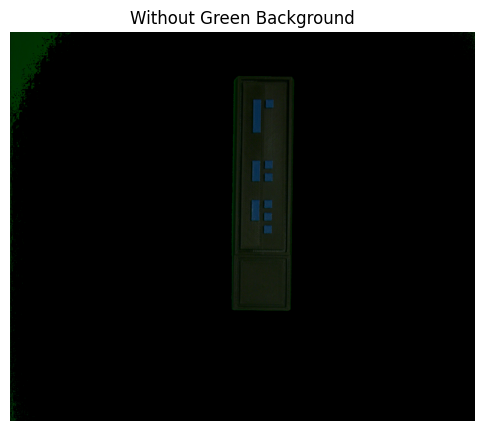

In [7]:
# Step 2: Remove green background
no_green, green_mask = remove_color_hsv(img, "green")
show_image(no_green, "Without Green Background")

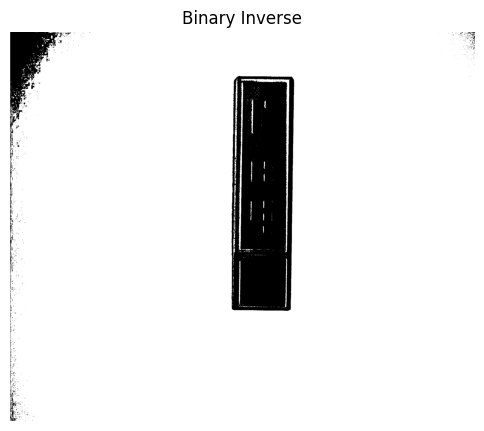

In [8]:
# Step 3: Binarize
gray, binary_inv = binarize_and_invert(no_green)
show_image(cv2.cvtColor(binary_inv, cv2.COLOR_GRAY2BGR), "Binary Inverse")

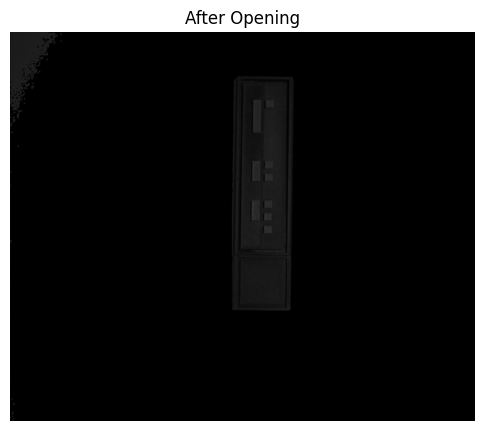

In [9]:
# Step 4: Morphological opening
gray_opened = apply_morphological_opening(gray, kernel_size=(5, 5), iterations=1)
show_image(cv2.cvtColor(gray_opened, cv2.COLOR_GRAY2BGR), "After Opening")

Total contours found: 69
Contours after area filter [10000, 200000]: 1


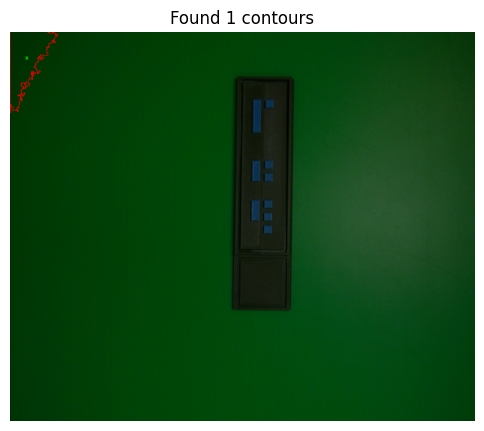

In [10]:
# Step 5: Find main contours
contours, contour_img = find_and_draw_contours_with_area_limits(
    binary_img=gray_opened,
    original_bgr=img,
    min_area=CONFIG["main_min_area"],
    max_area=CONFIG["main_max_area"]
)
show_image(contour_img, f"Found {len(contours)} contours")

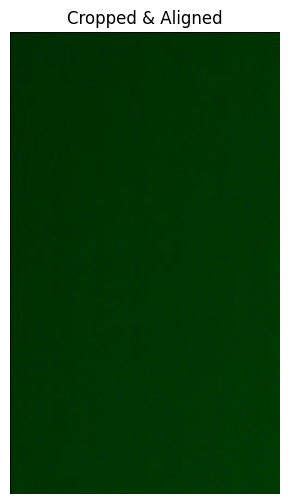

In [11]:
# Step 6: Get main contour and crop/align
main_cnt = max(contours, key=cv2.contourArea)
cropped_aligned = crop_and_align_vertical(img, main_cnt)
show_image(cropped_aligned, "Cropped & Aligned")

In [12]:
# Step 7: Detect piece color
piece_color, size_label, is_consistent, color_counts = detect_piece_color_and_check_size(
    img_bgr=img,
    contour=main_cnt,
    small_area_max=CONFIG["small_area_max"],
    medium_area_max=CONFIG["medium_area_max"],
)
print(f"Piece color: {piece_color}")
print(f"Size label: {size_label}")
print(f"Color consistent: {is_consistent}")
print(f"Color counts: {color_counts}")

Piece color: blue
Size label: SMALL
Color consistent: False
Color counts: {'blue': 0, 'yellow': 0, 'red': 0}


Total contours found: 0
Contours after area filter [100, 200000]: 0


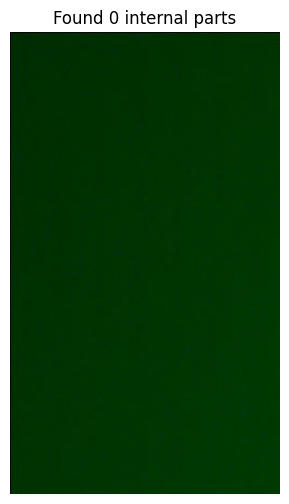

In [13]:
# Step 8: Detect internal parts
part_contours, part_contour_img, mask_closed = detect_color_parts(
    cropped_aligned, piece_color, debug=False
)
show_image(part_contour_img, f"Found {len(part_contours)} internal parts")

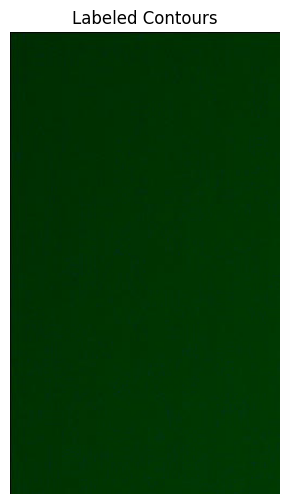

In [14]:
# Step 9: Extract features and label contours
features_list = extract_contour_features(part_contours)

for f in features_list:
    f["label"] = label_contour_by_extent_and_area(
        f,
        extent_threshold=CONFIG["extent_threshold"],
        small_area_max=CONFIG["label_small_area_max"],
        medium_area_max=CONFIG["label_medium_area_max"]
    )

# Display labeled contours
labeled_img = draw_labeled_contours_colored(
    cropped_aligned, part_contours, features_list,
    extent_threshold=CONFIG["extent_threshold"],
    small_area_max=CONFIG["label_small_area_max"],
    medium_area_max=CONFIG["label_medium_area_max"]
)
show_image(labeled_img, "Labeled Contours")

# Print labels
for f in features_list:
    print(f"Contour {f['index']}: {f['label']} (area={f['area']:.0f}, extent={f['extent']:.2f})")

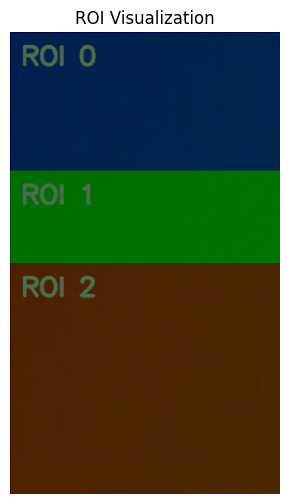

ROI 0 (y: 0-129): {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 1 (y: 129-215): {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 2 (y: 215-430): {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}


In [15]:
# Step 10: Compute ROIs and decode values
rois, boundaries = split_fixed_horizontal_rois_and_count(
    image_shape=cropped_aligned.shape,
    features_list=features_list,
    piece_color=piece_color,
)

# Visualize ROIs
roi_vis = draw_horizontal_rois_from_boundaries(cropped_aligned, boundaries, alpha=0.3)
show_image(roi_vis, "ROI Visualization")

# Print ROI counts
for r in rois:
    print(f"ROI {r['index']} (y: {r['y_start']}-{r['y_end']}): {r['counts']}")

In [16]:
# Step 11: Decode digits from ROI counts
decoded_digits = []
for r in rois:
    try:
        digit = decode_roi_to_number(r["counts"])
        decoded_digits.append(digit)
        print(f"ROI {r['index']} -> digit: {digit}")
    except ValueError as e:
        print(f"ROI {r['index']} -> ERROR: {e}")
        decoded_digits.append(None)

# Compute total value
total_value = compute_total_value_from_rois(decoded_digits, piece_color)
print(f"\nTotal value: {total_value}")

ROI 0 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 1 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}
ROI 2 -> ERROR: Invalid SMALL count for pure-small digit: {'marker': 0, 'small': 0, 'medium': 0, 'large': 0, 'unknown': 0}

Total value: None


## 5. Batch Processing Multiple Images

In [17]:
# Process all test images
import os

image_folder = "images"
results = []

for filename in os.listdir(image_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        filepath = os.path.join(image_folder, filename)
        print(f"\nProcessing: {filename}")
        
        try:
            _, img = load_source_cv2(filepath)
            result = process_piece(img, debug=False)
            
            results.append({
                "file": filename,
                "color": result.piece_color,
                "size": result.size_label,
                "consistent": result.is_consistent,
                "value": result.total_value,
            })
            print(f"  -> {result.piece_color} {result.size_label}: value={result.total_value}")
            
        except Exception as e:
            print(f"  -> ERROR: {e}")

print("\n=== Summary ===")
for r in results:
    print(f"{r['file']}: {r['color']} {r['size']} = {r['value']} (consistent={r['consistent']})")


Processing: blue.png
Total contours found: 69
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
  -> blue SMALL: value=None

Processing: blue_rotated.png
Total contours found: 69
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
  -> blue SMALL: value=None

Processing: fake.png
Total contours found: 68
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
  -> blue SMALL: value=None

Processing: red.png
Total contours found: 61
Contours after area filter [10000, 200000]: 2
Total contours found: 5
Contours after area filter [100, 200000]: 0
  -> red BIG: value=None

Processing: yellow.png
Total contours found: 85
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
  -> blue SMALL: value=None

Processing: yellow_rotated.png
Total contours fo

## 6. Create Comparison Grid

Total contours found: 69
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
Total contours found: 69
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
Total contours found: 68
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
Total contours found: 61
Contours after area filter [10000, 200000]: 2
Total contours found: 5
Contours after area filter [100, 200000]: 0
Total contours found: 85
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0
Total contours found: 85
Contours after area filter [10000, 200000]: 1
Total contours found: 0
Contours after area filter [100, 200000]: 0


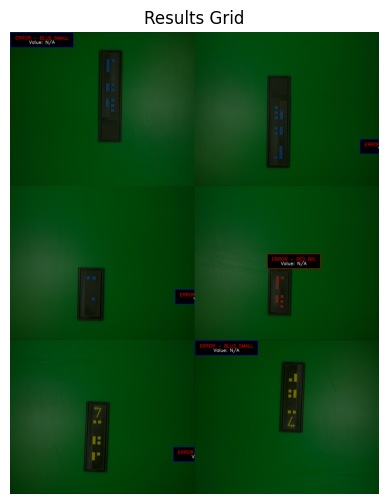

In [18]:
# Create a grid of annotated results
import os

image_folder = "images"
annotated_images = []

for filename in os.listdir(image_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        filepath = os.path.join(image_folder, filename)
        try:
            _, img = load_source_cv2(filepath)
            result = process_piece(img, debug=False)
            annotated_images.append(resize_to_screen(result.annotated_image, 400, 400))
        except Exception:
            pass

# Create grid (2 images per row)
rows = []
for i in range(0, len(annotated_images), 2):
    row_imgs = annotated_images[i:i+2]
    if row_imgs:
        rows.append(make_row(row_imgs))

if rows:
    grid = make_grid(rows)
    show_image(grid, "Results Grid")

---

## 7. Interactive GUI Application

The library includes an interactive Tkinter GUI for parameter tuning and real-time camera processing.

In [3]:
# Import the GUI module
from stb600_lib.gui import run_pipeline_gui, PipelineApp

# Launch the interactive pipeline GUI with an initial image
# Uncomment and run to start:

# run_pipeline_gui("images/blue.png")

# Or with camera enabled:
# run_pipeline_gui(use_camera=True)

# Or without any initial image (use "Load image" button in GUI):
# run_pipeline_gui()

### GUI Tabs Overview

The GUI provides the following interactive tabs for parameter tuning:

| Tab | Description |
|-----|-------------|
| **0) Input** | Load images or toggle camera, select piece color |
| **1) Remove green** | Adjust HSV thresholds for background removal |
| **2) Binarize** | Adjust binarization threshold |
| **3) Opening** | Tune morphological opening kernel and iterations |
| **4) Big contours** | Filter contours by area thresholds |
| **4b) Cropped main** | View cropped and aligned main piece |
| **5) Inner parts** | Detect internal colored parts |
| **6) Labeled** | Label parts as marker/small/medium/large + rotation if needed|
| **7) ROIs** | Define ROI regions and count parts |

Each tab shows real-time results as you adjust the sliders.

In [5]:
# Run this cell to launch the GUI
# (uncomment the line below)

run_pipeline_gui("images/blue.png")

Image rotated 180° - re-detecting contours...


In [6]:
# Import and run the Result Viewer
from stb600_lib.gui import run_result_viewer

# Launch the result viewer GUI
# This opens a window where you can:
# - Load an image with the "Load Image" button
# - The pipeline runs automatically
# - See the detected color, size, and VALUE
# - Bounding box is drawn around the detected piece

run_result_viewer()

Total contours found: 69
Contours after area filter [10000, 500000]: 2
Total contours found: 10
Contours after area filter [100, 200000]: 9
Total contours found: 68
Contours after area filter [10000, 500000]: 2
Total contours found: 7
Contours after area filter [100, 200000]: 3
Total contours found: 61
Contours after area filter [10000, 500000]: 2
Total contours found: 6
Contours after area filter [100, 200000]: 6
Total contours found: 68
Contours after area filter [10000, 500000]: 2
Total contours found: 7
Contours after area filter [100, 200000]: 3
